# Import libraries

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from google.colab import drive
# from keras.utils import timeseries_dataset_from_array
from sklearn.preprocessing import LabelEncoder
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# EDA

### Read the data

In [766]:
# Mount the drive to read the data
drive.mount('/content/drive')
#Read the data with geopandas
gdf = gpd.read_file('/content/drive/MyDrive/traffic_gdf_6month.gpkg')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Drop unnecessary columns


In [767]:
gdf.drop(columns=['date','traffic_id','geometry','traffic_status','weather','street_name' ,'day_name','average_car_speed'], inplace=True)
#We dropped geometry because we are dealing with average case - no need for specific points
#We dropped date, weather, street_name, traffic_status, traffic_id,average_car_speed, day_name because it's not useful in outrcase

In [768]:
gdf.head()

,time_series,number_of_cars
0,2023-01-01 06:00:00,960
1,2023-01-01 06:00:00,889
2,2023-01-01 06:00:00,876
3,2023-01-01 06:00:00,1438
4,2023-01-01 06:00:00,1124


# Dealing with Time_series column

### Convert Time_series column to datetime

In [769]:
#Convert the - time_series - column to datetime format
gdf['time_series'] = pd.to_datetime(gdf['time_series'])

### Set the column as index

In [770]:
#Set the column as index
gdf.set_index('time_series', inplace=True)

### Extract the average from each day

In [771]:
# Sum all record in each day 'D' then .mean() which is getting the average
daily_average = gdf.resample('D').mean()

In [772]:
daily_average.head()

,number_of_cars
time_series,
2023-01-01,840.571478
2023-01-02,837.850648
2023-01-03,844.151080
2023-01-04,845.300432
2023-01-05,889.302996


In [773]:
# After we make sure that our feature engineering is correct, we will assign it to new dataframe for more understanding
gdf_filtered = daily_average

# Prepare the data for the model

In [774]:
tf.random.set_seed(42)

### Scale the data

In [775]:
# Scale the data using MinMaxScaler (0,1) - default scaler
scaler = MinMaxScaler()
# Applying Scaler
gdf_filtered['number_of_cars'] = scaler.fit_transform(gdf_filtered[['number_of_cars']])

In [776]:
gdf_filtered.head()

,number_of_cars
time_series,
2023-01-01,0.039053
2023-01-02,0.023360
2023-01-03,0.059700
2023-01-04,0.066329
2023-01-05,0.320129


### Create sequence

In [777]:
# Time steps define how many steps will be used as input , using = 1 as default
# Which data will be observation
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):
        X.append(data.iloc[i:(i + time_steps), 0])
        y.append(data.iloc[i + time_steps, 0])
    return np.array(X), np.array(y)

In [778]:
# Define the steps to create sequence, in our case we used 28 -
time_steps = 28

# Create sequences to our target
X, y = create_sequences(gdf_filtered[['number_of_cars']], time_steps)

# Reshape X for LSTM input - ( samples , time_steps , features )
X = X.reshape((X.shape[0], time_steps, 1))  # using 1 for a single feature which is number_of_cars


### Train-test split

In [779]:
train_size = int(len(X) * 0.7) # 0.7 of the data will be as training
val_size = int(len(X) * 0.15) # 0.15 will be as validation
test_size = len(X) - train_size - val_size # Rest of them will be as testing data

In [780]:
# Assign the values to X,y
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Building LSTM Model

### Model Architecture



In [781]:
# Define sequential model
model_LSTM = Sequential()
#Define the input layer - X_train.shape[1] = number of time steps , X_train.shape[2] = number of features
model_LSTM.add(LSTM(50, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#First hidden layer containing 50 node
model_LSTM.add(LSTM(50, activation='tanh', return_sequences=False))
# Dropout layer to reduce overfitting
model_LSTM.add(Dropout(0.2))
# Output layer for regression
model_LSTM.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Model Summary

In [782]:
model_LSTM.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                       │ (None, 28, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_29 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

### Compile the model

In [783]:
# Using adam as optimazer with mean absolute error as loss function
model_LSTM.compile(optimizer='adam', loss='mae',metrics=['mae'])

### Train the model

In [784]:
# Train the model with training data with validate it using valudating data, 100 epochs with 32 batch size
history_LSTM = model_LSTM.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.3295 - mae: 0.3295 - val_loss: 0.2997 - val_mae: 0.2997
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2910 - mae: 0.2910 - val_loss: 0.3066 - val_mae: 0.3066
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3034 - mae: 0.3034 - val_loss: 0.3017 - val_mae: 0.3017
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3027 - mae: 0.3027 - val_loss: 0.2923 - val_mae: 0.2923
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2886 - mae: 0.2886 - val_loss: 0.2873 - val_mae: 0.2873
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2835 - mae: 0.2835 - val_loss: 0.2891 - val_mae: 0.2891
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2808 - mae: 0.2808 - val_loss: 0.2845 - val_mae: 0.2845
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2795 - mae: 0.2795 - val_loss: 0.2841 - val_mae: 0.2841
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2803 - mae:

### Prediction

In [785]:
# Predict on test data with our model
y_pred_LSTM = model_LSTM.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


### Inverse the predicted data to the original scale

In [786]:
y_test_inv_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv_LSTM = scaler.inverse_transform(y_pred_LSTM)

### Evaluate the model

In [787]:
# Evaluate the model
mse = mean_squared_error(y_test_inv_LSTM, y_pred_inv_LSTM)
mae = mean_absolute_error(y_test_inv_LSTM, y_pred_inv_LSTM)
# Show results
print(f"Mean Squared Error on Test Data: {mse}")
print(f"Mean Absolute Error on Test Data: {mae}")

Mean Squared Error on Test Data: 178.5369301825356
Mean Absolute Error on Test Data: 10.902090899717393


### Ploting model performance

### Plot for the actual and predicted values

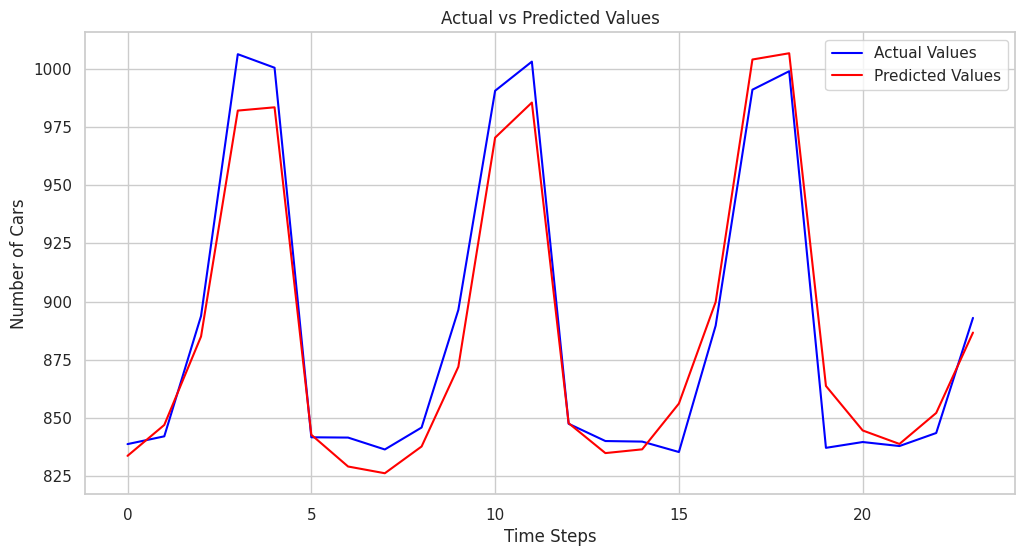

In [788]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv_LSTM, label='Actual Values', color='blue')
plt.plot(y_pred_inv_LSTM, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Number of Cars')
plt.legend()
plt.show()

### Plot for training and validation loss

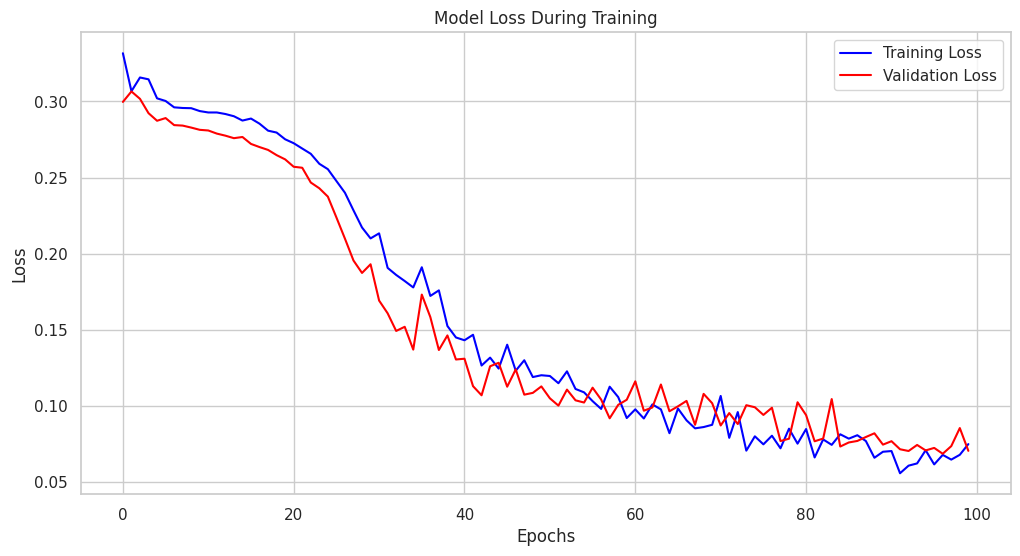

In [789]:
plt.figure(figsize=(12, 6))
plt.plot(history_LSTM.history['loss'], label='Training Loss', color='blue')
plt.plot(history_LSTM.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Building RNN Model

### Model Architecture



In [790]:
# Define sequential model
model_RNN = Sequential()
#Define the input layer - X_train.shape[1] = number of time steps , X_train.shape[2] = number of features
model_RNN.add(SimpleRNN(50, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#First hidden layer containing 50 node
model_RNN.add(LSTM(50, activation='tanh', return_sequences=False))
# Dropout layer to reduce overfitting
model_RNN.add(Dropout(0.2))
# Output layer for regression
model_RNN.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Model Summary

In [791]:
model_RNN.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_8 (SimpleRNN)             │ (None, 28, 50)              │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_30 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,851 (89.26 KB)

 Trainable params: 22,851 (89.26 KB)

 Non-trainable params: 0 (0.00 B)

### Compile the model

In [792]:
# Using adam as optimazer with mean absolute error as loss function
model_RNN.compile(optimizer='adam', loss='mae',metrics=['mae'])

### Train the model

In [793]:
# Train the model with training data with validate it using valudating data, 100 epochs with 32 batch size
history_RNN = model_RNN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.3446 - mae: 0.3446 - val_loss: 0.2962 - val_mae: 0.2962
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.2731 - mae: 0.2731 - val_loss: 0.2319 - val_mae: 0.2319
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2382 - mae: 0.2382 - val_loss: 0.1731 - val_mae: 0.1731
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1828 - mae: 0.1828 - val_loss: 0.1360 - val_mae: 0.1360
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1406 - mae: 0.1406 - val_loss: 0.1104 - val_mae: 0.1104
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1467 - mae: 0.1467 - val_loss: 0.1010 - val_mae: 0.1010
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1280 - mae: 0.1280 - val_loss: 0.0783 - val_mae: 0.0783
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.1165 - mae: 0.1165 - val_loss: 0.0472 - val_mae: 0.0472
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0958 - mae:

### Prediction

In [794]:
# Predict on test data with our model
y_pred = model_RNN.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


### Inverse the predicted data to the original scale

In [795]:
y_test_inv_RNN = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv_RNN = scaler.inverse_transform(y_pred)

### Evaluate the model

In [796]:
# Evaluate the model
mse = mean_squared_error(y_test_inv_RNN, y_pred_inv_RNN)
mae = mean_absolute_error(y_test_inv_RNN, y_pred_inv_RNN)
# Show results
print(f"Mean Squared Error on Test Data: {mse}")
print(f"Mean Absolute Error on Test Data: {mae}")

Mean Squared Error on Test Data: 29.306627535209554
Mean Absolute Error on Test Data: 3.9195579659958164


### Ploting model performance

### Plot for the actual and predicted values

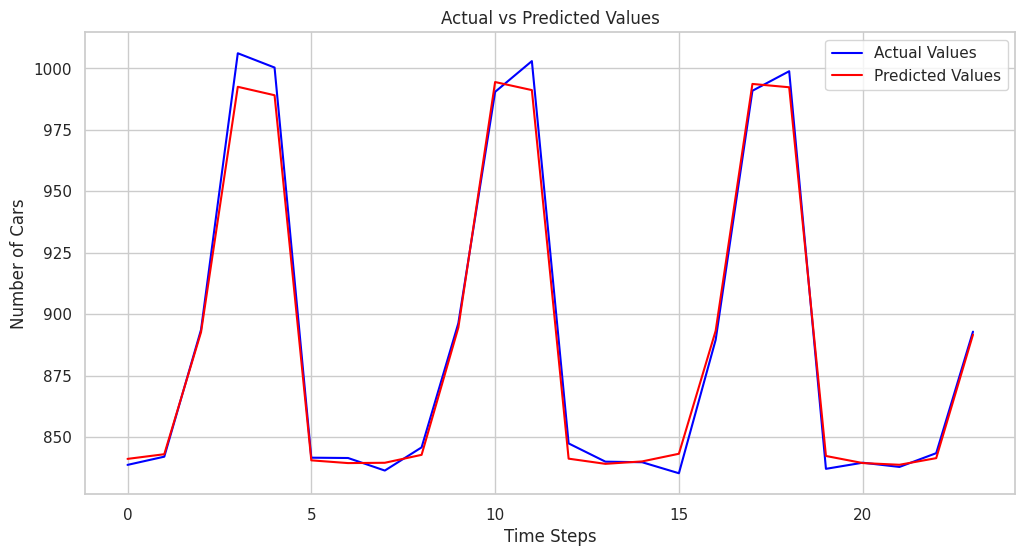

In [797]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv_RNN, label='Actual Values', color='blue')
plt.plot(y_pred_inv_RNN, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Number of Cars')
plt.legend()
plt.show()

### Plot for training and validation loss

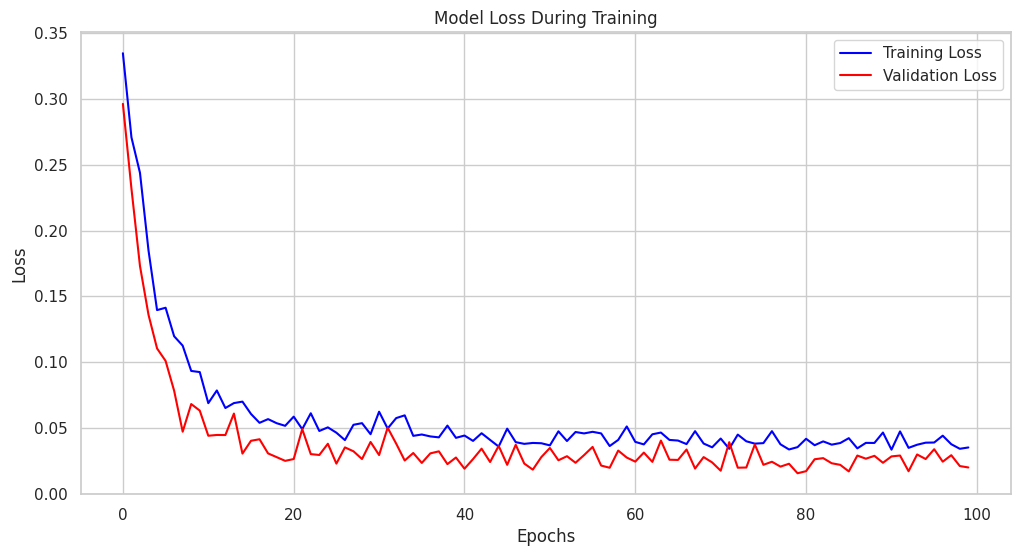

In [798]:
plt.figure(figsize=(12, 6))
plt.plot(history_RNN.history['loss'], label='Training Loss', color='blue')
plt.plot(history_RNN.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Building GRU Model

### Model Architecture



In [799]:
# Define sequential model
model_GRU = Sequential()
#Define the input layer - X_train.shape[1] = number of time steps , X_train.shape[2] = number of features
model_GRU.add(GRU(50, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#First hidden layer containing 50 node
model_GRU.add(GRU(50, activation='tanh', return_sequences=False))
# Dropout layer to reduce overfitting
model_GRU.add(Dropout(0.2))
# Output layer for regression
model_GRU.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Model Summary

In [800]:
model_GRU.summary()

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_28 (GRU)                         │ (None, 28, 50)              │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_29 (GRU)                         │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

### Compile the model

In [801]:
# Using adam as optimazer with mean absolute error as loss function
model_GRU.compile(optimizer='adam', loss='mae',metrics=['mae'])

### Train the model

In [802]:
# Train the model with training data with validate it using valudating data, 100 epochs with 32 batch size
history_GRU = model_GRU.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.3006 - mae: 0.3006 - val_loss: 0.3130 - val_mae: 0.3130
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3011 - mae: 0.3011 - val_loss: 0.2954 - val_mae: 0.2954
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2883 - mae: 0.2883 - val_loss: 0.2873 - val_mae: 0.2873
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2910 - mae: 0.2910 - val_loss: 0.2805 - val_mae: 0.2805
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2794 - mae: 0.2794 - val_loss: 0.2781 - val_mae: 0.2781
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2724 - mae: 0.2724 - val_loss: 0.2701 - val_mae: 0.2701
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2670 - mae: 0.2670 - val_loss: 0.2633 - val_mae: 0.2633
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2564 - mae: 0.2564 - val_loss: 0.2566 - val_mae: 0.2566
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2522 - mae: 

### Prediction

In [803]:
# Predict on test data with our model
y_pred = model_GRU.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


### Inverse the predicted data to the original scale

In [804]:
y_test_inv_GRU = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv_GRU = scaler.inverse_transform(y_pred)

### Evaluate the model

In [805]:
# Evaluate the model
mse = mean_squared_error(y_test_inv_GRU, y_pred_inv_GRU)
mae = mean_absolute_error(y_test_inv_GRU, y_pred_inv_GRU)
# Show results
print(f"Mean Squared Error on Test Data: {mse}")
print(f"Mean Absolute Error on Test Data: {mae}")

Mean Squared Error on Test Data: 83.57281867019348
Mean Absolute Error on Test Data: 6.769997448574543


### Ploting model performance

### Plot for the actual and predicted values

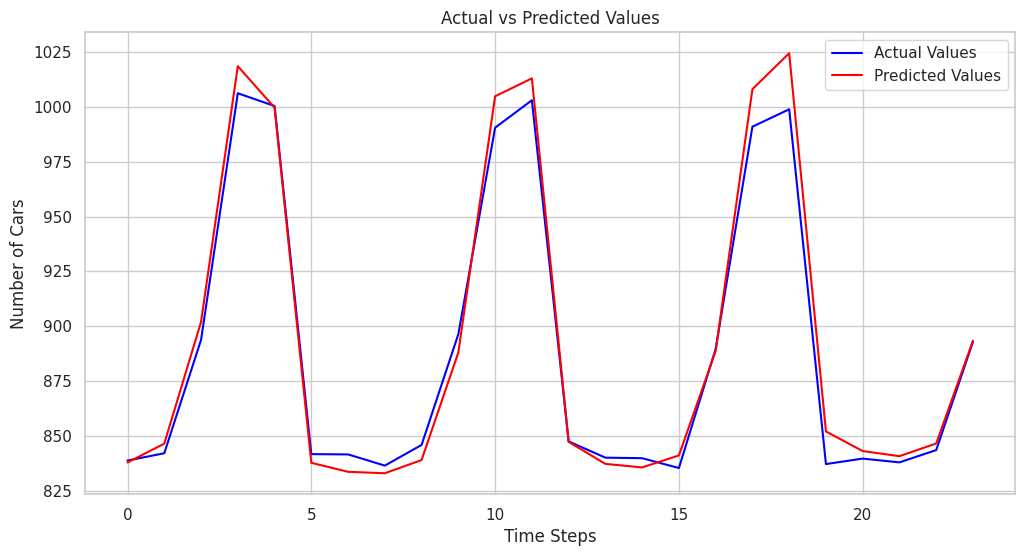

In [806]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv_GRU, label='Actual Values', color='blue')
plt.plot(y_pred_inv_GRU, label='Predicted Values', color='red')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Number of Cars')
plt.legend()
plt.show()

### Plot for training and validation loss

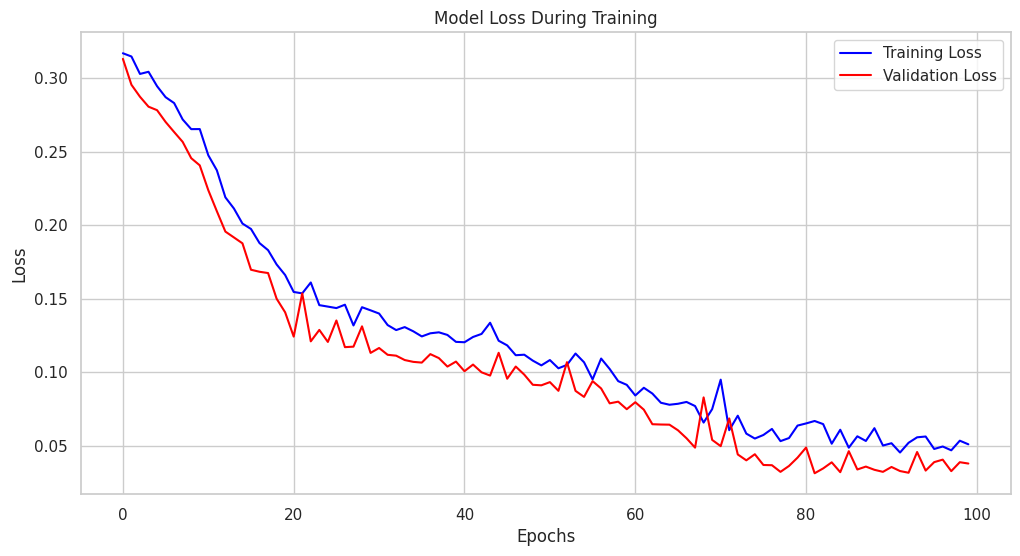

In [807]:
plt.figure(figsize=(12, 6))
plt.plot(history_GRU.history['loss'], label='Training Loss', color='blue')
plt.plot(history_GRU.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Forcasting - LSTM

### Define the parameters

### Define the start point of predections and future steps for prediction


In [808]:
# Number of steps to predict, in our case 30 = 1 month
future_steps = 30
future_predictions = []

# Last element from test data
last_sequence = X_test[-1].reshape(1, time_steps, 1)

### Forcast the steps

In [809]:
for _ in range(future_steps):
    # Predict the next time step
    next_pred = model_LSTM.predict(last_sequence)

    # Reshape to (1, 1, 1) for appending
    next_pred = next_pred.reshape(1, 1, 1)

    # Append to predictions
    future_predictions.append(next_pred[0, 0, :])

    next_pred_repeated = np.repeat(next_pred, last_sequence.shape[2], axis=2)

   # Adding the new predictions with historical the data
    new_sequence = np.concatenate([last_sequence[:, 1:, :], next_pred_repeated], axis=1)
    # Update the sequences
    last_sequence = new_sequence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━

### Dealing with the predictions

In [810]:
# Convert predictions to numpy array
future_predictions = np.array(future_predictions).reshape(future_steps, 1)

# Inverse transform to make predictions in the origincal values - scale -
future_predictions = scaler.inverse_transform(future_predictions)

# Prepare the predictions for visualization
future_dates = pd.date_range(start=gdf_filtered.index[-1] + pd.Timedelta(days=1), periods=future_steps)
predicted_df = pd.DataFrame(future_predictions, index=future_dates, columns=['Predictions_LSTM'])

In [811]:
# Inverse scale for the historical data - to make it in original scale
gdf_filtered['number_of_cars'] = scaler.inverse_transform(gdf_filtered[['number_of_cars']])

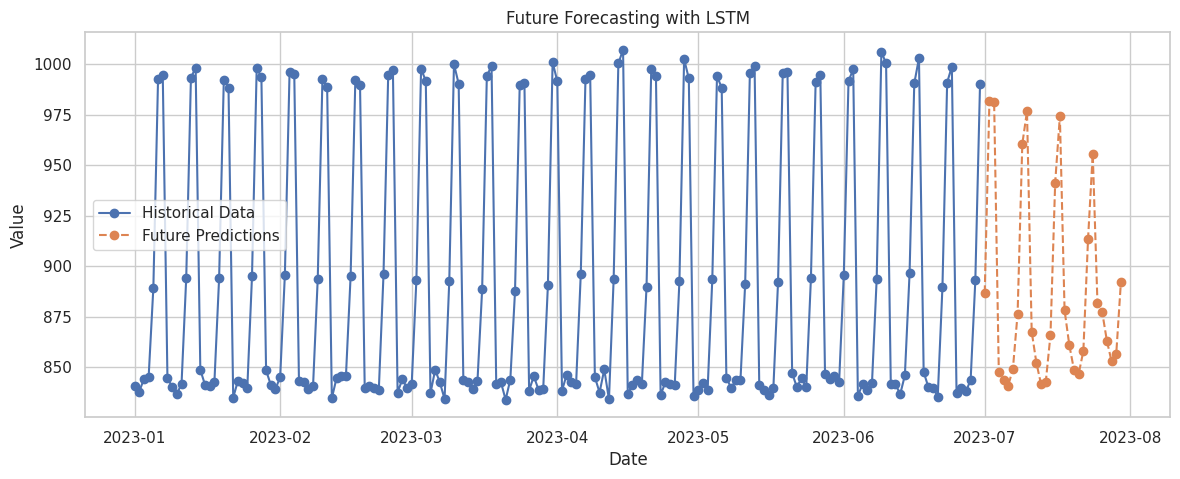

In [812]:
# Merge our historical data with the predictions values
combined = pd.concat([gdf_filtered, predicted_df], axis=1)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(combined['number_of_cars'], label='Historical Data', marker='o')
plt.plot(combined['Predictions_LSTM'], label='Future Predictions', marker='o', linestyle='--')
plt.title('Future Forecasting with LSTM')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

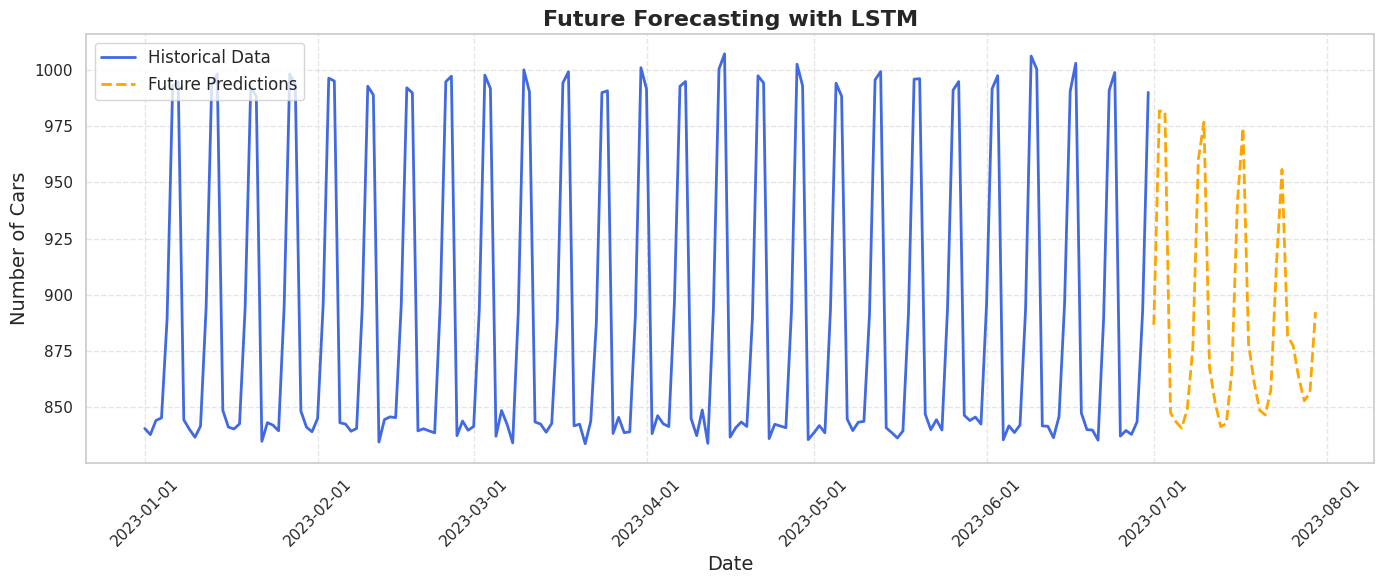

In [814]:
# Set the style using seaborn
sns.set(style='whitegrid')

# Create a figure with a specified size
plt.figure(figsize=(14, 6))

# Plot the historical data
plt.plot(combined.index, combined['number_of_cars'], label='Historical Data', color='royalblue', linewidth=2)

# Plot the predicted data
plt.plot(combined.index, combined['Predictions_LSTM'], label='Future Predictions', linestyle='--', color='orange', linewidth=2)

# Customize title and labels
plt.title('Future Forecasting with LSTM', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Cars', fontsize=14)

# Format x-axis for better date readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show ticks every week
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format date
plt.xticks(rotation=45)  # Rotate x labels for better readability

# Add a legend
plt.legend(loc='upper left', fontsize=12)

# Add gridlines for better visibility
plt.grid(visible=True, linestyle='--', alpha=0.5)

# Adjust layout to make sure everything fits without overlap
plt.tight_layout()

# Show the plot
plt.show()


# Forcasting - GRU

### Define the parameters

### Define the start point of predections and future steps for prediction


In [815]:
# Number of steps to predict, in our case 30 = 1 month
future_steps = 30
future_predictions = []

# Last element from test data
last_sequence = X_test[-1].reshape(1, time_steps, 1)

### Forcast the steps

In [816]:
for _ in range(future_steps):
    # Predict the next time step
    next_pred = model_GRU.predict(last_sequence)

    # Reshape to (1, 1, 1) for appending
    next_pred = next_pred.reshape(1, 1, 1)

    # Append to predictions
    future_predictions.append(next_pred[0, 0, :])

    next_pred_repeated = np.repeat(next_pred, last_sequence.shape[2], axis=2)

   # Adding the new predictions with historical the data
    new_sequence = np.concatenate([last_sequence[:, 1:, :], next_pred_repeated], axis=1)
    # Update the sequences
    last_sequence = new_sequence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

### Dealing with the predictions

In [817]:
# Convert predictions to numpy array
future_predictions_GRU = np.array(future_predictions).reshape(future_steps, 1)

# Inverse transform to make predictions in the origincal values - scale -
future_predictions_GRU = scaler.inverse_transform(future_predictions_GRU)

# Prepare the predictions for visualization
future_dates = pd.date_range(start=gdf_filtered.index[-1] + pd.Timedelta(days=1), periods=future_steps)
predicted_df_GRU = pd.DataFrame(future_predictions, index=future_dates, columns=['Predictions_GRU'])

In [818]:
# Inverse transform to make predictions in the origincal values - scale -
future_predictions = scaler.inverse_transform(future_predictions)

# Prepare the predictions for visualization
future_dates = pd.date_range(start=gdf_filtered.index[-1] + pd.Timedelta(days=1), periods=future_steps)
predicted_df_GRU = pd.DataFrame(future_predictions, index=future_dates, columns=['Predictions_GRU'])

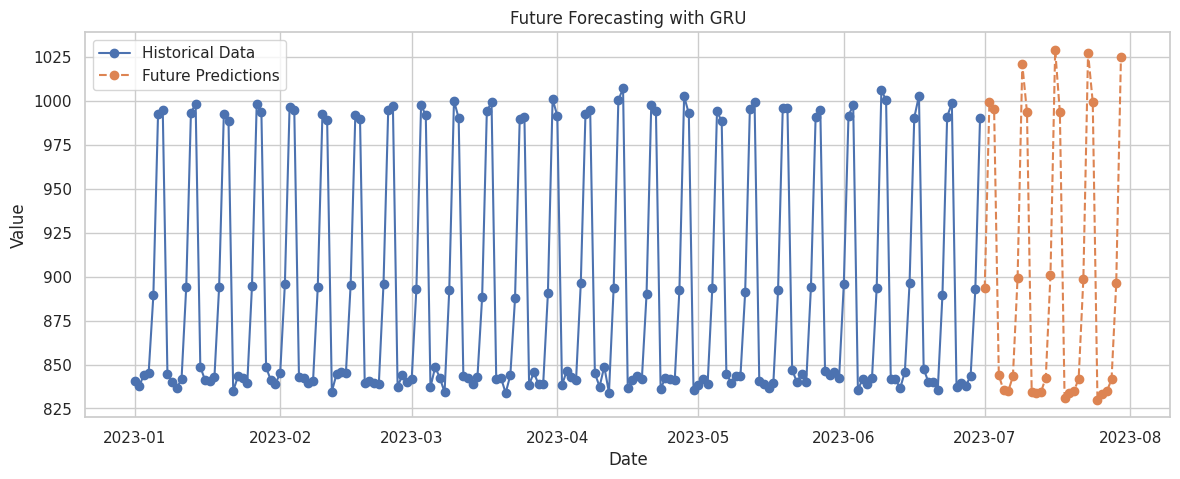

In [819]:
# Merge our historical data with the predictions values
combined_GRU = pd.concat([gdf_filtered, predicted_df_GRU], axis=1)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(combined_GRU['number_of_cars'], label='Historical Data', marker='o')
plt.plot(combined_GRU['Predictions_GRU'], label='Future Predictions', marker='o', linestyle='--')
plt.title('Future Forecasting with GRU')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

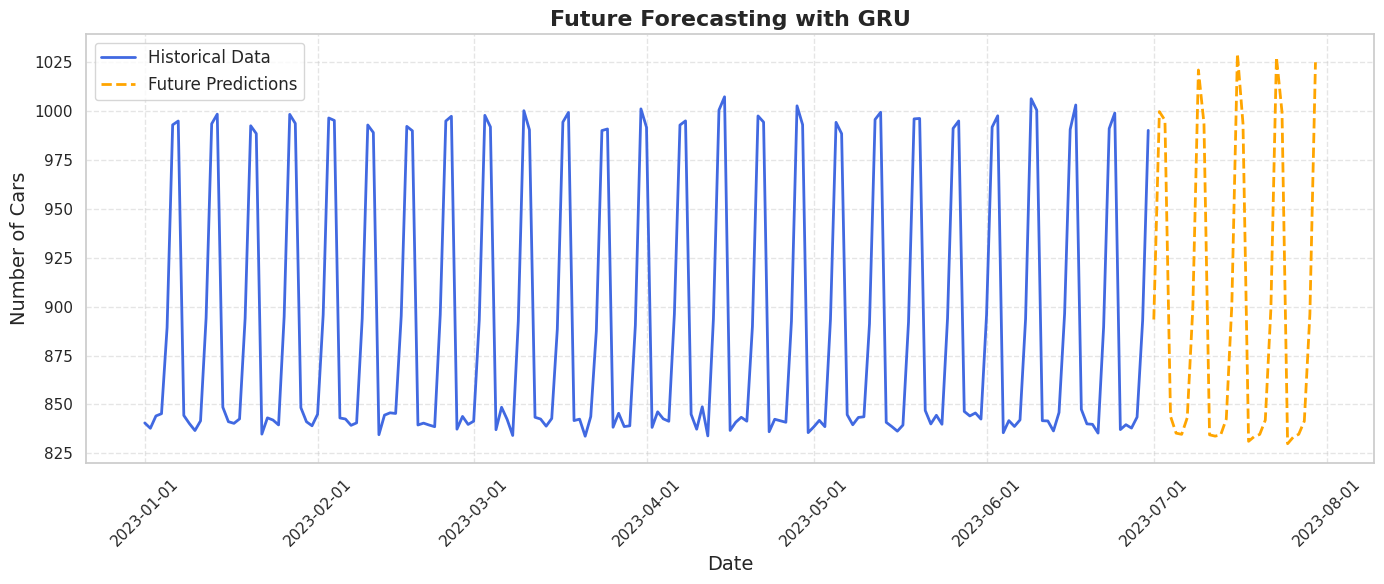

In [820]:
# Set the style using seaborn
sns.set(style='whitegrid')

# Create a figure with a specified size
plt.figure(figsize=(14, 6))

# Plot the historical data
plt.plot(combined_GRU.index, combined_GRU['number_of_cars'], label='Historical Data', color='royalblue', linewidth=2)

# Plot the predicted data
plt.plot(combined_GRU.index, combined_GRU['Predictions_GRU'], label='Future Predictions', linestyle='--', color='orange', linewidth=2)

# Customize title and labels
plt.title('Future Forecasting with GRU', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Cars', fontsize=14)

# Format x-axis for better date readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show ticks every week
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format date
plt.xticks(rotation=45)  # Rotate x labels for better readability

# Add a legend
plt.legend(loc='upper left', fontsize=12)

# Add gridlines for better visibility
plt.grid(visible=True, linestyle='--', alpha=0.5)

# Adjust layout to make sure everything fits without overlap
plt.tight_layout()

# Show the plot
plt.show()


# Forcasting - RNN

### Define the parameters

### Define the start point of predections and future steps for prediction


In [821]:
# Number of steps to predict, in our case 30 = 1 month
future_steps = 30
future_predictions = []

# Last element from test data
last_sequence = X_test[-1].reshape(1, time_steps, 1)

### Forcast the steps

In [822]:
for _ in range(future_steps):
    # Predict the next time step
    next_pred = model_RNN.predict(last_sequence)

    # Reshape to (1, 1, 1) for appending
    next_pred = next_pred.reshape(1, 1, 1)

    # Append to predictions
    future_predictions.append(next_pred[0, 0, :])

    next_pred_repeated = np.repeat(next_pred, last_sequence.shape[2], axis=2)

   # Adding the new predictions with historical the data
    new_sequence = np.concatenate([last_sequence[:, 1:, :], next_pred_repeated], axis=1)
    # Update the sequences
    last_sequence = new_sequence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━

### Dealing with the predictions

In [823]:
# Convert predictions to numpy array
future_predictions = np.array(future_predictions).reshape(future_steps, 1)

# Inverse transform to make predictions in the origincal values - scale -
future_predictions = scaler.inverse_transform(future_predictions)

# Prepare the predictions for visualization
future_dates = pd.date_range(start=gdf_filtered.index[-1] + pd.Timedelta(days=1), periods=future_steps)
predicted_df_RNN = pd.DataFrame(future_predictions, index=future_dates, columns=['Predictions_RNN'])

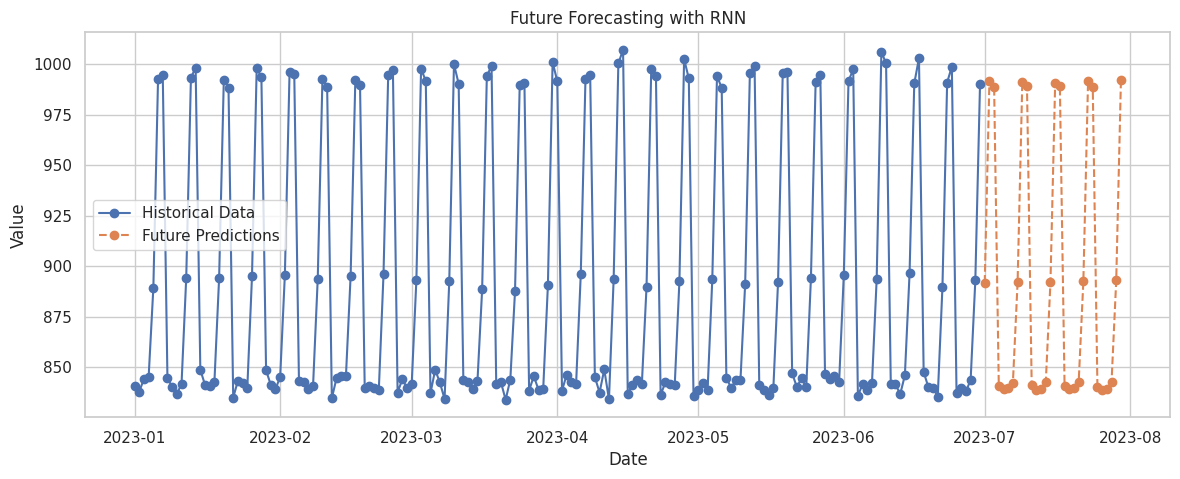

In [824]:
# Merge our historical data with the predictions values
combined_RNN = pd.concat([gdf_filtered, predicted_df_RNN], axis=1)

# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(combined_RNN['number_of_cars'], label='Historical Data', marker='o')
plt.plot(combined_RNN['Predictions_RNN'], label='Future Predictions', marker='o', linestyle='--')
plt.title('Future Forecasting with RNN')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

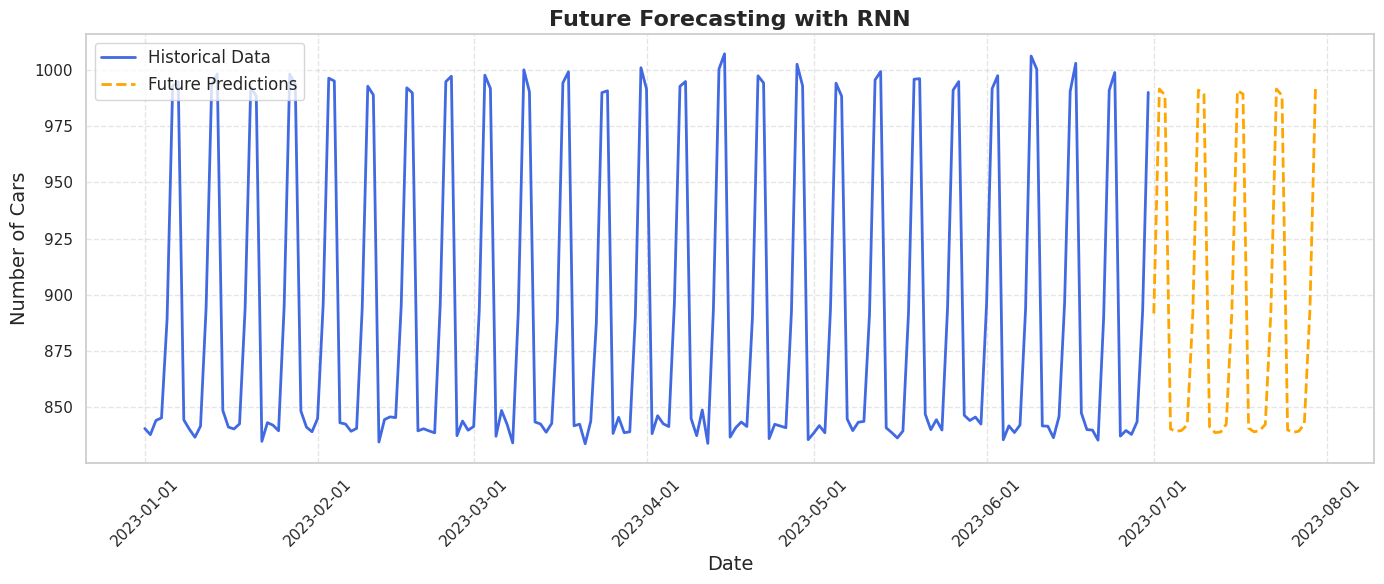

In [825]:
# Set the style using seaborn
sns.set(style='whitegrid')

# Create a figure with a specified size
plt.figure(figsize=(14, 6))

# Plot the historical data
plt.plot(combined_RNN.index, combined_RNN['number_of_cars'], label='Historical Data', color='royalblue', linewidth=2)

# Plot the predicted data
plt.plot(combined_RNN.index, combined_RNN['Predictions_RNN'], label='Future Predictions', linestyle='--', color='orange', linewidth=2)

# Customize title and labels
plt.title('Future Forecasting with RNN', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Cars', fontsize=14)

# Format x-axis for better date readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show ticks every week
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format date
plt.xticks(rotation=45)  # Rotate x labels for better readability

# Add a legend
plt.legend(loc='upper left', fontsize=12)

# Add gridlines for better visibility
plt.grid(visible=True, linestyle='--', alpha=0.5)

# Adjust layout to make sure everything fits without overlap
plt.tight_layout()

# Show the plot
plt.show()


# Save the model

In [826]:
model_LSTM.save('LSTM_TimeSeries.h5')
model_GRU.save('GRU_TimeSeries.h5')
model_RNN.save('RNN_TimeSeries.h5')

### Merge all predections to one csv file

In [827]:
combined_df = pd.concat([gdf_filtered, predicted_df, predicted_df_GRU, predicted_df_RNN]) # Combine the predicted values with historical data as same column

### Convert to geopandas - In case needed

In [831]:
combined_df = pd.concat([gdf_filtered, predicted_df, predicted_df_GRU, predicted_df_RNN],axis=1, join='outer', ignore_index=True, verify_integrity=True)

In [839]:
combined_df = combined_df.rename(columns={0: 'Historical Data', 1: 'LSTM Predictions', 2: 'GRU Predictions', 3: 'RNN Predictions'})

In [842]:
combined_df = gpd.GeoDataFrame(combined_df) # Convert it to GeoDataframe

In [843]:
combined_df

,Historical Data,LSTM Predictions,GRU Predictions,RNN Predictions
2023-01-01,840.571478,NaN,NaN,NaN
2023-01-02,837.850648,NaN,NaN,NaN
2023-01-03,844.151080,NaN,NaN,NaN
2023-01-04,845.300432,NaN,NaN,NaN
2023-01-05,889.302996,NaN,NaN,NaN
...,...,...,...,...
2023-07-26,NaN,877.389160,833.281678,838.845520
2023-07-27,NaN,863.144958,834.804117,839.362793
2023-07-28,NaN,852.858887,841.514185,842.533142
2023-07-29,NaN,856.488037,896.263041,892.995056


### Save the data with multiple extensions

In [844]:
# CSV file
combined_df.to_csv('TrafficTimeSeries.csv')
# gpkg for geometry purpose if needed in future
combined_df.to_file('TrafficTimeSeries.gpkg', driver='GPKG')
# geojson another type of geometry
combined_df.to_file('TrafficTimeSeries.geojson', driver='GeoJSON')